In [10]:
import numpy as np
import itertools
from scipy.special import expit
import scipy.optimize as optimize

class LogisticRegression:
    def __init__(self,X: np.ndarray,
                 y: np.ndarray,
                 degree: int = 1,
                 lam: int = 0,
                 normalize: bool = False):
        if X.ndim == 1: 
            X = X[:,None]
        self.mu = self.sigma = None
        if normalize:
            X,self.mu,self.sigma = self.FeatureNormalize(X)
        m,n = X.shape
        self.degree = degree
        self.lam = lam
        self.X = self.generate_polynomial(X,degree=degree)
        self.m,self.n = self.X.shape
        self.y = np.array(y,copy=True)
    def __call__(self,
                 *args,
                 theta: np.ndarray = None,
                 **kwargs) -> np.ndarray:
        res = []
        def callback(x):
            res.append([*x,self.J(x)])
        m,n = self.m,self.n
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = np.zeros(n)
        optimize.minimize(self.J,theta,jac=self.dJdTheta,**kwargs,callback=callback)
        res = np.array(res)
        return res[:,:-1],res[:,-1]
    def generate_polynomial(self,
                            X: np.ndarray,
                            degree: int = 1) -> np.ndarray:
        m,n = X.shape
        perm = itertools.product(
                range(degree+1),repeat=n)
        powers = []
        for p in list(perm):
            if(np.sum(p)<=degree):
                powers.append(p)
        powers = np.array(powers)
        X_new = []
        for row in X:
            res = []
            for p in powers:
                res.append(np.prod(row**p))
            X_new.append(res)
        X_new = np.array(X_new)
        return X_new
    def FeatureNormalize(self,
                         X: np.ndarray) -> np.ndarray:
        X = np.array(X,copy=True)
        m,n = X.shape
        mu = np.mean(X,axis=0)
        sigma = np.std(X,axis=0,ddof=1)
        for i in range(n):
            X[:,i] = (X[:,i] - mu[i])/(sigma[i] + 1e-100)
        return X,mu,sigma
    def _h(self,
           z: np.ndarray) -> np.ndarray:
        #return 1./(1. + np.exp(-z))
        return expit(z)
    def h(self,
          X: np.ndarray,
          theta: np.ndarray) -> np.ndarray:
        z = X@theta
        return self._h(z)
    def J(self,
          theta: np.ndarray) -> np.ndarray:
        m,n = self.m,self.n
        lam = self.lam
        z = self.X@theta
        j = ( 1/m*(-self.y@np.log(self._h(z) + 1e-100) 
              - (1 - self.y)@np.log(1 - self._h(z) + 1e-100)) 
              + lam/(2*m)*theta[1:]@theta[1:])
        return j
    def dJdTheta(self,
                 theta: np.ndarray) -> np.ndarray:
        m,n = self.m,self.n
        lam = self.lam
        z = self.X@theta
        dJ = 1/m*self.X.T@(self._h(z)-self.y) + lam/m*theta
        dJ[0] = dJ[0] - lam/m*theta[0]
        return dJ
    def costfunction(self,
                     theta: np.ndarray) -> tuple:
        m,n = self.m,self.n
        lam = self.lam
        z = self.X@theta
        J = ( 1/m*(-self.y@np.log(self._h(z) + 1e-100) 
              - (1 - self.y)@np.log(1 - self._h(z) + 1e-100)) 
              + lam/(2*m)*theta[1:]@theta[1:])
        dJ = 1/m*self.X.T@(self._h(z)-self.y) + lam/m*theta
        dJ[0] = dJ[0] - lam/m*theta[0]
        return J,dJ
    def GradientDescent(self,
                        alpha: float = 1.0,
                        steps: int = 1000,
                        adagrad: bool = True,
                        theta: np.ndarray = None) -> tuple:
        # gradient descent modified with adagrad learning rate.
        # set adagrad = False to turn off 
        m,n = self.m,self.n
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = np.zeros(n)
        res = []
        s = 0
        Jprev = 0
        for i in range(steps):
            J,dJ = self.costfunction(theta)
            if adagrad:
                s += dJ@dJ
                theta = theta - alpha/np.sqrt(s + 1e-8)*dJ
                Jprev = J
            else:
                theta = theta - alpha*dJ
            res.append([*theta,J])
        res = np.array(res)
        _theta = res[:,:-1]
        _J = res[:,-1]
        return _theta,_J 
    def predict(self,
                X: np.ndarray,
                theta: np.ndarray) -> tuple:
        X = np.array(X,copy=True)
        if self.mu is not None:
            if X.ndim == 1: 
                X = X[:,None]
            m,n = X.shape
            for i in range(n):
                X[:,i] = (X[:,i] - self.mu[i])/(self.sigma[i] + 1e-100) 
        X = self.generate_polynomial(X,degree=self.degree) 
        theta = np.array(theta,copy=True)
        p = self.h(X,theta)
        return p,(p >= 0.5)

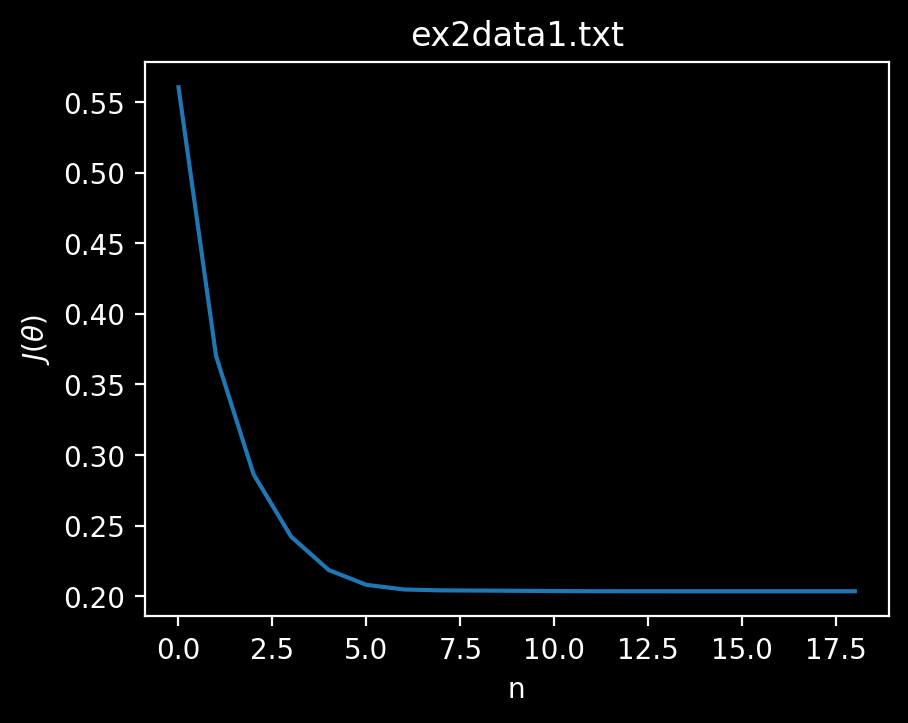

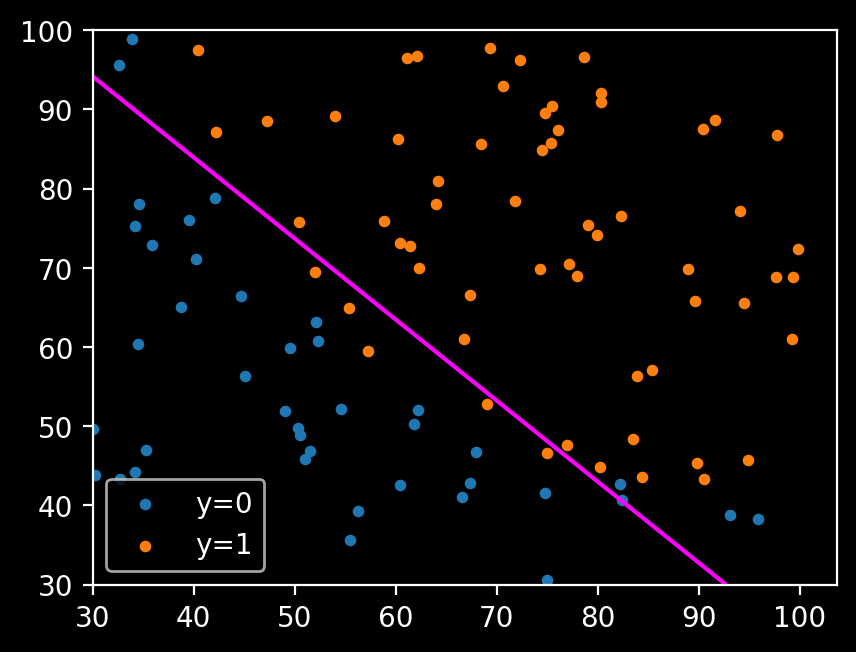

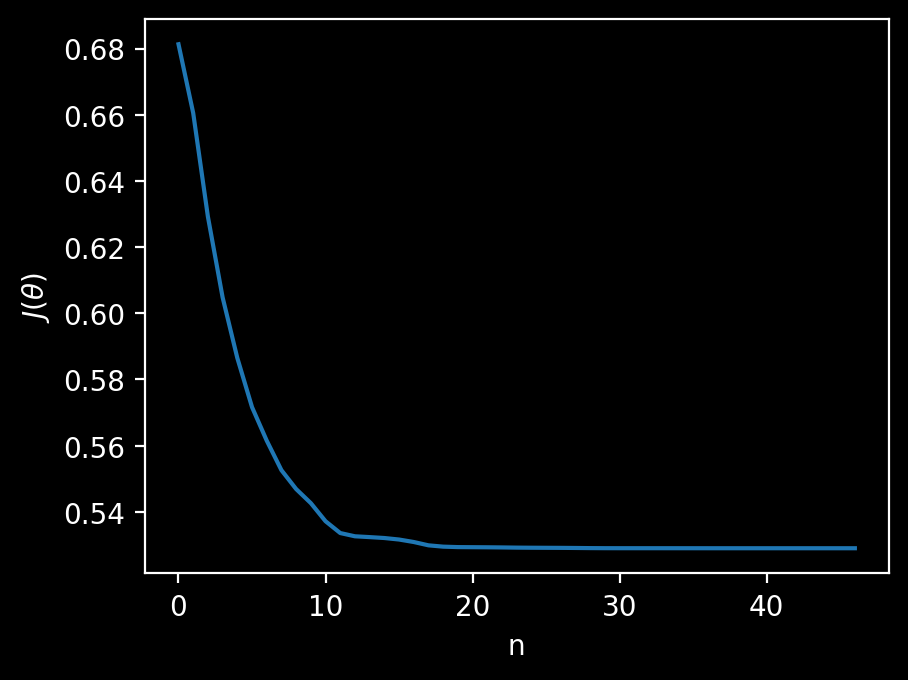

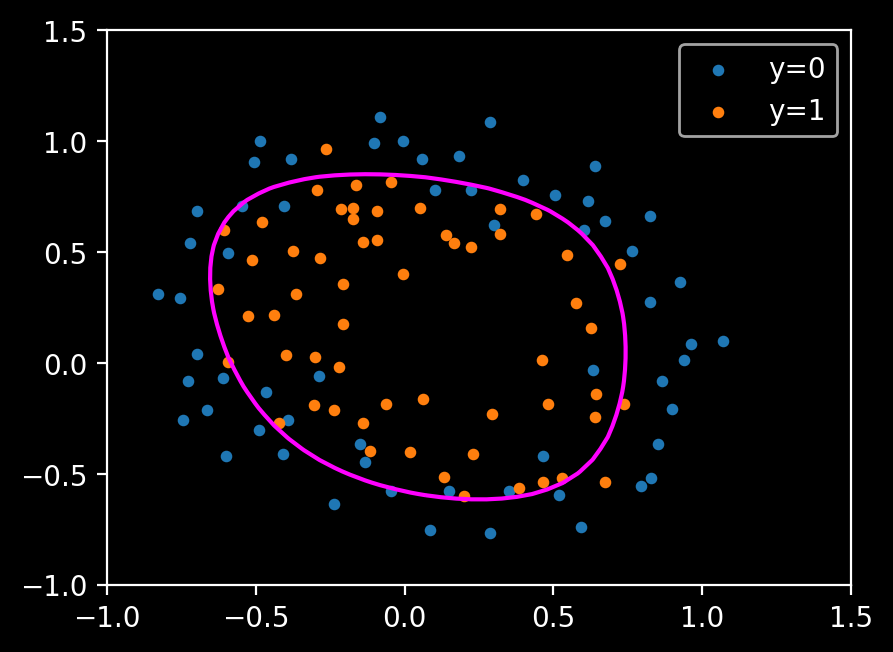

In [11]:
if (__name__ == "__main__") :
    import matplotlib.pyplot as plt
    file = ["ex2data1.txt","ex2data2.txt"]

    _file = file[0]

    with open(_file,"rb") as f:
        data = np.loadtxt(f,delimiter=",")
    X = data[:,0:-1]
    y = data[:,-1]

    LR = LogisticRegression(X,y,degree=1,normalize=True)
    _theta,J = LR()
    theta = _theta[-1]

    fig,ax = plt.subplots()
    ax.set(xlabel="n",ylabel=r"$J(\theta)$",title=_file)
    ax.plot(J)
    plt.show()

    neg = np.where(y == 0)
    pos = np.where(y == 1)
    x = np.linspace(30,100,50)
    x1,x2 = np.meshgrid(x,x)
    x = np.column_stack((x1.ravel(),x2.ravel()))
    p,_ = LR.predict(x,theta)
    p = p.reshape(*x1.shape)

    fig,ax = plt.subplots()
    ax.set(xlabel="",
           ylabel="")
    plt.scatter(X[:,0][neg],X[:,1][neg],label="y=0",s=10)
    plt.scatter(X[:,0][pos],X[:,1][pos],label="y=1",s=10)
    cs = plt.contour(x1,x2,p,
                     levels=[0.5],
                     colors="magenta")
    plt.legend()
    plt.show()
    
    _file = file[1]
    with open(_file,"rb") as f:
        data = np.loadtxt(f,delimiter=",")
    X = data[:,0:-1]
    y = data[:,-1]

    LR = LogisticRegression(X,y,
                            degree=6,
                            lam=1,
                            normalize=False)
    _theta,J = LR()
    theta = _theta[-1]

    fig,ax = plt.subplots()
    ax.set(xlabel="n",ylabel=r"$J(\theta)$")
    ax.plot(J)
    plt.show()


    neg = np.where(y == 0)
    pos = np.where(y == 1)
    x = np.linspace(-1,1.5,50)
    x1,x2 = np.meshgrid(x,x)
    x = np.column_stack((x1.ravel(),x2.ravel()))
    p,_ = LR.predict(x,theta)
    p = p.reshape(*x1.shape)

    fig,ax = plt.subplots()
    ax.set(xlabel="",
           ylabel="")
    plt.scatter(X[:,0][neg],X[:,1][neg],label="y=0",s=10)
    plt.scatter(X[:,0][pos],X[:,1][pos],label="y=1",s=10)
    cs = plt.contour(x1,x2,p,
                     levels=[0.5],
                     colors="magenta")
    plt.legend()
    plt.show()
